In [4]:
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
from discrete_exterior_calculus import DEC
from icosphere import icosphere
from jax import config

config.update("jax_enable_x64", False)


# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
nu = 1
vertices, faces = icosphere(nu=nu)
mesh_name = f"icosphere_v={len(vertices)}"
mesh = DEC.Mesh(vertices, faces)

print("highest vertex: ", jnp.max(vertices))

zmost_point = jnp.argmax(vertices[:, 2])
zleast_point = jnp.argmin(vertices[:, 2])
xmost_point = jnp.argmax(vertices[:, 0])
xleast_point = jnp.argmin(vertices[:, 0])
ymost_point = jnp.argmax(vertices[:, 1])
yleast_point = jnp.argmin(vertices[:, 1])

n = len(vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    u = y[:n]
    v = y[n:]
    # Compute derivatives
    du_dt = v
    dv_dt = jnp.tanh(mesh.laplace_matrix @ u)
    # Combine derivatives
    return jnp.concatenate([du_dt, dv_dt])


# Define the ODE term
term = ODETerm(vector_field)

end_time = 10
# Solver settings
solver = Kvaerno5()  # Runge-Kutta method
saveat = SaveAt(
    ts=jnp.linspace(0, end_time, 100)
)  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
v0 = jnp.zeros(n)  # Initial condition for v (e.g., zero velocity)
u0 = u0.at[ymost_point].set(1.0)  # Example: Displace the middle point
y0 = jnp.concatenate([u0, v0])  # Combine u0 and v0 into a single state vector


# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time,
    dt0=0.01,
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

highest vertex:  0.8506508


In [53]:
def taylor_coef_diag(h: float, state: int, derivatives: int) -> jnp.ndarray:
    elements: jnp.ndarray = jnp.arange(derivatives, -1, -1)
    factorial = jnp.cumprod(jnp.arange(1, derivatives + 1))[::-1]
    factorial = jnp.concatenate([factorial, jnp.array([1])])
    elements = jnp.power(h, elements)
    elements = elements / factorial
    return jnp.repeat(elements, state + 1) * jnp.sqrt(h)


def taylor_matrix(h: float, state: int, derivatives: int) -> jnp.ndarray:
    diag = taylor_coef_diag(h, state, derivatives)
    return jnp.diag(diag)


def inverse_taylor_matrix(h: float, state: int, derivatives: int) -> jnp.ndarray:
    diag = taylor_coef_diag(h, state, derivatives)
    return jnp.diag(1 / diag)


(taylor_matrix(0.1, 1, 2) @ inverse_taylor_matrix(0.1, 1, 2)).round(4)

Array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

has nan:  mean: False std: False


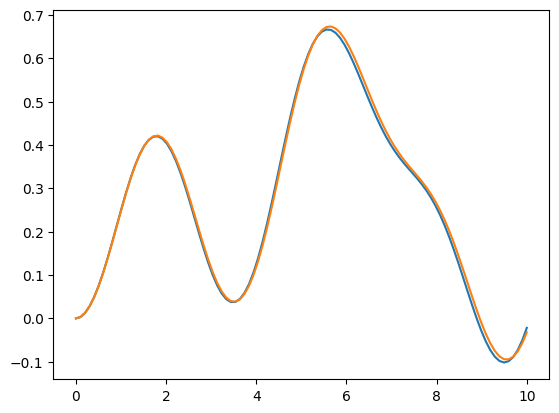

In [13]:
import probabilistic_solve_icosphere
import matplotlib.pyplot as plt

means, stds = probabilistic_solve_icosphere.solve(
    isosphere_nu=1,
    timesteps=300,
    derivatives=2,
    prior="iwp",
)

print("has nan: ", "mean:", jnp.any(jnp.isnan(means)), "std:", jnp.any(jnp.isnan(stds)))

plt.plot(sol.ts, diffrax_sol[:, zmost_point], label="Diffrax")
plt.plot(sol.ts, means[:, zmost_point], label="Probabilistic")